In [1]:
import numpy as np
import re, json, csv
import torch
from matplotlib import pyplot as plt
from pymongo import MongoClient
from tqdm.notebook import tqdm
from pprint import PrettyPrinter
from typing import Union, Iterable
from bson.objectid import ObjectId
from torchmetrics.text.bert import BERTScore
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text.bleu import BLEUScore
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoConfig, AutoTokenizer
from torchmetrics.functional import pairwise_cosine_similarity
from torchmetrics.functional.text.bert import _get_precision_recall_f1
from functools import partial
from collections import Counter, defaultdict
from itertools import chain
from math import log
from multiprocessing import Pool
from typing import List
from pymongo import MongoClient
from typing import Set

pprint = PrettyPrinter().pprint

In [2]:
DEVICE = "cpu"

In [3]:
db = MongoClient("mongodb://localhost:27017")["cuda_snippets"]
train_db = db["train"]
validation_db = db["validation"]

### Get model

### Calculate ROUGE

In [4]:
def compute_rouge_score(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer):
    tokenizer_fn = lambda x: tokenizer.convert_ids_to_tokens(tokenizer.encode(x))
    rouge_metric = ROUGEScore(tokenizer=tokenizer_fn)
    # rouge_metric.update(pred_senteces, target_sentences)
    return rouge_metric(pred_senteces, target_sentences)

### Calculate BLEU

In [5]:
def compute_bleu_score(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer):
    bleu_metric = BLEUScore(tokenizer=tokenizer)
    bleu_metric.update(pred_senteces, [[s] for s in target_sentences])
    return bleu_metric.compute()

### Calculate BERT score

In [6]:
def update(self, preds: List[str], targets: List[str]) -> None:
        """Store predictions/references for computing BERT scores.

        It is necessary to store sentences in a tokenized form to ensure the DDP mode working.
        """
        
        preds_tokenized_data = self.tokenizer(preds, max_length=1024, truncation=True, return_tensors="pt", padding=True)
        preds_dict = {"input_ids": preds_tokenized_data["input_ids"], "attention_mask": preds_tokenized_data["attention_mask"]}
        target_tokenized_data = self.tokenizer(targets, max_length=1024, truncation=True, return_tensors="pt", padding=True)
        target_dict = {"input_ids": target_tokenized_data["input_ids"], "attention_mask": target_tokenized_data["attention_mask"]}

        self.preds_input_ids.append(preds_dict["input_ids"])
        self.preds_attention_mask.append(preds_dict["attention_mask"])
        self.target_input_ids.append(target_dict["input_ids"])
        self.target_attention_mask.append(target_dict["attention_mask"])
        
def compute_bert_score2(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer, model : torch.nn.Module, *args, **kwargs):
    BERTScore.update = update
    user_forward_fn = lambda model, d: model.get_input_embeddings()(d["input_ids"])
    bert_metric = BERTScore(model=model, user_tokenizer=tokenizer, user_forward_fn=user_forward_fn, device=DEVICE, verbose=True, num_layers=0, max_length=600)
    # bert_metric.update = update
    output = {}
    for key, vals in bert_metric(preds=pred_senteces, targets=target_sentences).items():
        output[key] = float(np.mean(vals))
    
    return output
#     bert_metric.update(bert_metric, pred_senteces, target_sentences)
#     return bert_metric.compute()

In [7]:
def get_kernel_prefixes(kernel : str) -> Set[str]:
    prefixes = set()
    one_line_kernel = kernel.replace("\n", " ")
    cuda_header_prefix_re = re.compile("__(host|global|device)__")
    
    prefixes.update(cuda_header_prefix_re.findall(one_line_kernel))
    return prefixes
        

In [9]:
def compute_metrics(sources : List[str], targets : List[str], preds : List[str], tokenizer, model : torch.nn.Module, used_ratio : float = 1.0):
    assert used_ratio > 0 and used_ratio <= 1
    assert len(targets) == len(preds)
    
    samples = list(zip(targets, preds))
    np.random.shuffle(samples)
    n = round(len(samples) * used_ratio)
    
    print(f"Using random {n} samples")
        
    metrics_d = {
        "device" : {},
        "host" : {},
        "global" : {}
    }
    
    device_sentences = []
    host_sentences = []
    global_sentences = []
    
    pb = tqdm(zip(sources, targets, preds))
    i = 0
    for src, target, pred in pb:
        found = False
        
        if found := (src.find("__device__") != -1):
            device_sentences.append((target, pred))
        if found := (src.find("__host__") != -1):
            host_sentences.append((target, pred))
        if found := (src.find("__global__") != -1):
            global_sentences.append((target, pred))
        
        if not found:
            continue
        
        i += 1
        pb.set_description_str(f"{i}")
        if i >= n:
            break
    
    if len(device_sentences) == 0:
        print("WARNING: no device sample")
        # metrics_d["__device__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        device_targets, device_preds = zip(*device_sentences)
        metrics_d["device"] = {
            "rouge" : compute_rouge_score(device_targets, device_preds, tokenizer),
            "bleu" : compute_bleu_score(device_targets, device_preds, tokenizer),
            "bert" : compute_bert_score2(device_targets, device_preds, tokenizer, model)
        }
        print(f"__device__ ({len(device_sentences)})")
        pprint(metrics_d["device"])
        
    if len(host_sentences) == 0:
        print("WARNING: no host samples")
        # metrics_d["__host__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        host_targets, host_preds = zip(*host_sentences)
        metrics_d["host"] = {
            "rouge" : compute_rouge_score(host_targets, host_preds, tokenizer),
            "bleu" : compute_bleu_score(host_targets, host_preds, tokenizer),
            "bert" : compute_bert_score2(host_targets, host_preds, tokenizer, model)
        }
        print(f"__host__ ({len(host_sentences)})")
        pprint(metrics_d["host"])
        
    if len(global_sentences) == 0:
        print("WARNING: no global samples")
        # metrics_d["__global__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        global_targets, global_preds = zip(*global_sentences)
        metrics_d["global"] = {
            "rouge" : compute_rouge_score(global_targets, global_preds, tokenizer),
            "bleu" : compute_bleu_score(global_targets, global_preds, tokenizer),
            "bert" : compute_bert_score2(global_targets, global_preds, tokenizer, model)
        }
        print(f"__global__ ({len(global_sentences)})")
        pprint(metrics_d["global"])
        
    # Weights 
    total = len(device_sentences) + len(host_sentences) + len(global_sentences)
    d_w = len(device_sentences) / total
    h_w = len(host_sentences) / total
    g_w = len(global_sentences) / total
    
    def calculate_total_metric(ds : List[dict], ws : List[float]):        
        def calculate(ds : List[dict], ws : List[float], key : str):
            r = 0
            for d, w in zip(ds, ws):
                if d is None:
                    continue
                
                r += d.get(key, 0) * w
            return r
        
        total_rouge = {}
        
        for d in ds:
            if d is None:
                continue
            for key in d.keys():
                if key in total_rouge:
                    continue
                
                total_rouge[key] = calculate(ds, ws, key)
        return total_rouge
    
    metrics_d["total"] = {"rouge" : {}, "bleu" : -1, "bert" : {}}
    metrics_d["total"]["rouge"] = calculate_total_metric(
        [metrics_d["device"].get("rouge"), metrics_d["host"].get("rouge"), metrics_d["global"].get("rouge")],
        [d_w, h_w, g_w]
    )
    
    metrics_d["total"]["bleu"] = metrics_d["device"].get("bleu",0)*d_w + metrics_d["host"].get("bleu",0)*h_w + metrics_d["global"].get("bleu",0)*g_w

    
    metrics_d["total"]["bert"] = calculate_total_metric(
        [metrics_d["device"].get("bert"), metrics_d["host"].get("bert"), metrics_d["global"].get("bert")],
        [d_w, h_w, g_w]
    )
    
    print("total")
    pprint(metrics_d["total"])
    
    # rouge = compute_rouge_score(targets, preds, tokenizer)
    # pprint({"rouge" : rouge})

    # bleu = compute_bleu_score(targets, preds, tokenizer)
    # pprint({"bleu" : bleu})

    # bert = compute_bert_score2(targets, preds, tokenizer, model)
    # pprint({"bert" : bert})
    
    return metrics_d

# BART

In [3]:

def get_bart_model(model_name : str, model_path : str, tokenizer):

    configuration = AutoConfig.from_pretrained(model_name)

    model = AutoModelForSeq2SeqLM.from_config(configuration).to(DEVICE)
    model.resize_token_embeddings(len(tokenizer))
    model_dict = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(model_dict["model_dict"])
    
    return model, model_dict

In [5]:

model_path = "../../../models/bart/bart.evaluated.pt"
tokenizer_name = "facebook/bart-large"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=False, model_max_length=800, add_bos_token=True)
model, model_d = get_bart_model(tokenizer_name, model_path, tokenizer)


In [19]:
used_ratio = 0.01
metrics = compute_metrics(model_d.get("source_sentences"), model_d.get("target_sentences"), model_d.get("pred_sentences"), tokenizer, model, used_ratio)

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/queues.py", line 266, in _feed
    queue_sem.releas

Using random 389 samples


0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f038f7fbdc0>
Traceback (most recent call last):
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/9 [00:20<?, ?it/s]

__device__ (520)
{'bert': {'f1': 0.587616716325283,
          'precision': 0.5443727339689548,
          'recall': 0.6573521455320028},
 'bleu': tensor(0.0190),
 'rouge': {'rouge1_fmeasure': tensor(0.2733),
           'rouge1_precision': tensor(0.1807),
           'rouge1_recall': tensor(1.),
           'rouge2_fmeasure': tensor(0.1231),
           'rouge2_precision': tensor(0.0855),
           'rouge2_recall': tensor(0.5154),
           'rougeL_fmeasure': tensor(0.2733),
           'rougeL_precision': tensor(0.1807),
           'rougeL_recall': tensor(1.),
           'rougeLsum_fmeasure': tensor(0.2706),
           'rougeLsum_precision': tensor(0.1788),
           'rougeLsum_recall': tensor(1.)}}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

__host__ (264)
{'bert': {'f1': 0.5618912665681406,
          'precision': 0.5053239637477831,
          'recall': 0.662569123461391},
 'bleu': tensor(0.0113),
 'rouge': {'rouge1_fmeasure': tensor(0.3063),
           'rouge1_precision': tensor(0.2009),
           'rouge1_recall': tensor(1.),
           'rouge2_fmeasure': tensor(0.1300),
           'rouge2_precision': tensor(0.0861),
           'rouge2_recall': tensor(0.5095),
           'rougeL_fmeasure': tensor(0.3063),
           'rougeL_precision': tensor(0.2009),
           'rougeL_recall': tensor(1.),
           'rougeLsum_fmeasure': tensor(0.3026),
           'rougeLsum_precision': tensor(0.1981),
           'rougeLsum_recall': tensor(1.)}}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

__global__ (389)
{'bert': {'f1': 0.7075400108083661,
          'precision': 0.7115276986804904,
          'recall': 0.7132776129061887},
 'bleu': tensor(0.0067),
 'rouge': {'rouge1_fmeasure': tensor(0.1463),
           'rouge1_precision': tensor(0.0829),
           'rouge1_recall': tensor(1.),
           'rouge2_fmeasure': tensor(0.0527),
           'rouge2_precision': tensor(0.0291),
           'rouge2_recall': tensor(0.4987),
           'rougeL_fmeasure': tensor(0.1463),
           'rougeL_precision': tensor(0.0829),
           'rougeL_recall': tensor(1.),
           'rougeLsum_fmeasure': tensor(0.1456),
           'rougeLsum_precision': tensor(0.0825),
           'rougeLsum_recall': tensor(1.)}}
total
{'bert': {'f1': 0.6215968039791907,
          'precision': 0.5910175813128576,
          'recall': 0.6770727669999625},
 'bleu': tensor(0.0132),
 'rouge': {'rouge1_fmeasure': tensor(0.2386),
           'rouge1_precision': tensor(0.1528),
           'rouge1_recall': tensor(1.),
        

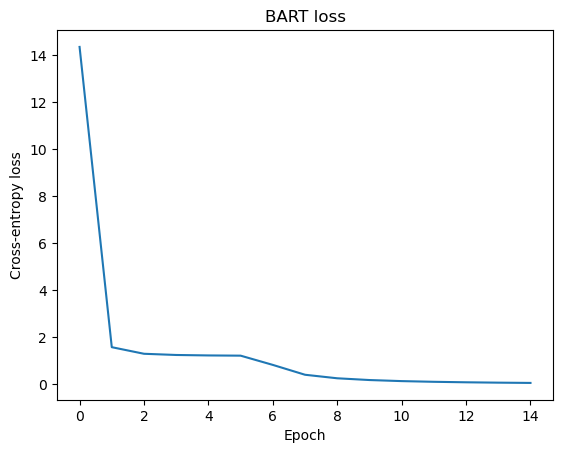

Epochs: 15
Max: 14.342219352722168, epoch: 0
Min: 0.0417606420814991, epoch: 14


In [12]:
loss_list = model_d.get("loss_list")
plt.figure()
plt.title("BART loss")
plt.ylabel("Cross-entropy loss")
plt.xlabel("Epoch")
plt.plot(loss_list)
plt.show()

print(f"Epochs: {len(loss_list)}")
print(f"Max: {max(loss_list)}, epoch: {np.argmax(loss_list)}")
print(f"Min: {min(loss_list)}, epoch: {np.argmin(loss_list)}")

### Average lengths

In [13]:
tgr_ls = 0
tgr_cs = 0
prd_ls = 0
prd_cs = 0
s = len(model_d.get("source_sentences"))
for tgr, prd in tqdm(zip(model_d.get("source_sentences"), model_d.get("target_sentences"))):
    # tgr = tgr.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat")
    # prd = prd.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat")
    
    tgr_ls += tgr.count("\n")
    prd_ls += prd.count("\n")
    
    tgr_cs += len(tgr)
    prd_cs += len(prd)
    
print("Average target lines per sample: {:.3f}".format(tgr_ls/s))
print("Average predic lines per sample: {:.3f}".format(prd_ls/s))
print("Average target sample size: {:.3f}".format(tgr_cs/s))
print("Average predic sample size: {:.3f}".format(prd_cs/s))


0it [00:00, ?it/s]

Average target lines per sample: 5.306
Average predic lines per sample: 21.523
Average target sample size: 278.344
Average predic sample size: 703.131


### Examples

In [30]:
# Generate random example from evaluation
samples = list(zip(model_d.get("source_sentences"), model_d.get("target_sentences"), model_d.get("pred_sentences")))
np.random.shuffle(samples)
for src, tgr, prd in zip(*zip(*samples)):
    
    if (len(tgr) > 100):
        continue
    
    print("SOURCE:")
    print(src)
    print("\nTARGET:")
    print(tgr)
    print("\nPREDICT:")
    # print(prd.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat"))
    print(prd)
    print("#--------------------------#")
    break

SOURCE:
// value

__global__ void VoteAllKernel2(unsigned int *input, unsigned int *result,
                               int size)<mask>

TARGET:
{
  int tx = threadIdx.x;

  int mask = 0xffffffff;
  result[tx] = __all_sync(mask, input[tx]);
}

PREDICT:
{
  int tid = threadIdx.x + blockDim.x*blockIdxreads();

  if (tid < size) return;

  printf("set World!ree!\n", a,id],�em[tid], tid, tid, stoping_op, stop[t]);
  // stop in sharedizes!\tid] = %0000[id + s, gridDim.  //
   if(tid == 1) {
  ) return;
  }
  else {
}
#--------------------------#


In [52]:
from transformers import pipeline, set_seed
model = model.eval()

while True:
    kernel = list(train_db.aggregate([
        {"$match" : {"metadata.correct_syntax" : True}},
        {"$sample" : {"size": 1}}
    ]))[0]
    
    if len(kernel["body"]) > 200:
        continue

    text_input = "{}{}<mask>".format(kernel["comment"], kernel["header"])

    print("INPUT:")
    print(text_input)

    print("\nTARGET:")
    print(kernel["body"])

    print("\nPREDICT:")
    x = tokenizer(text_input, return_tensors="pt")
    print(tokenizer.batch_decode(model.generate(**x, max_new_tokens=256), skip_special_tokens=True)[0])
    break

    # print(generator(text_input, max_length=256, num_return_sequences=1)[0]["generated_text"])


INPUT:
// Initialize privatized bin counters.  Specialized for privatized shared-memory counters
__device__ __forceinline__ void InitBinCounters()<mask>

TARGET:
{
    if (prefer_smem)
        InitSmemBinCounters();
    else
        InitGmemBinCounters();
}

PREDICT:
{
    if (smem_raking_ptr > linear_tid / blockDim.raizedPLNon_SPNon_2)
  { The smem: % num_full and zero and grid-I >= 0\n", g_PER_TRACKed(0], linear_index, (SPASGetMENT, linear_SPVEC) + (RGB_THREAD)) + local_TYPE) * 0) * num_REERS_VEC_RGB_TYPE> << num_valid_blocks, 0) + src_TYPE_V_dimRow_dim << 3, stream);

   // Copy from the local_share[threadIdx.y + block_rows, 0, input.y;

  }

  int for (int i = 0; col<int i < gridDim.x < 0; i)
}


In [14]:
prompt = """
// Kernel for dividing by two
__device__ float divideByTwo(float v)
""".strip()

target = """
{
    return v / 2;
}
""".strip()

In [63]:
x = tokenizer(prompt, max_length=100, padding=True, truncation=True, return_tensors="pt")
y = tokenizer(target, max_length=100, padding=True, truncation=True, return_tensors="pt")

input_tokens = [token.replace("Ġ", " ").replace("Ċ", "\n") for token in tokenizer.convert_ids_to_tokens(x["input_ids"][0], skip_special_tokens=True)]
target_tokens = [token.replace("Ġ", " ").replace("Ċ", "\n") for token in tokenizer.convert_ids_to_tokens(y["input_ids"][0], skip_special_tokens=True)]

output = model(**x, labels=y["input_ids"], output_attentions=True)
logits = output.logits
pred = torch.argmax(logits, dim=-1)
pred_tokens = [token.replace("Ġ", " ").replace("Ċ", "\n") for token in tokenizer.convert_ids_to_tokens(pred[0])]
print(f"Loss: {output.loss:.3f}")
print(tokenizer.batch_decode(pred, skip_special_tokens=True)[0])

Loss: 1.583
{
  return  return v - v.
}


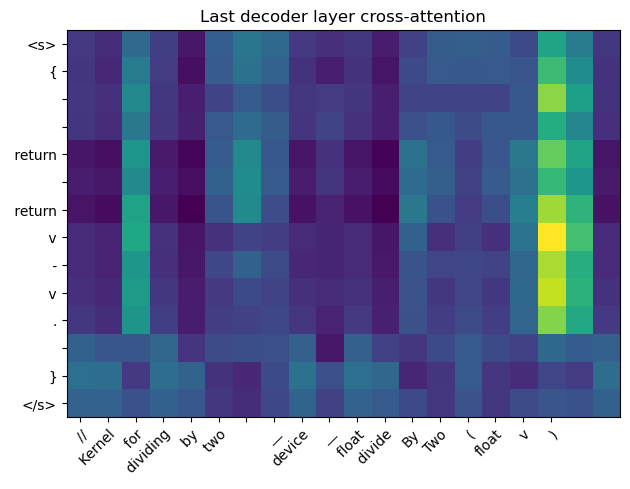

In [64]:
last_cross_attention = output.cross_attentions[-1]
attention = torch.sum(last_cross_attention, dim=1).squeeze().detach().numpy()
# plt.imshow(attention)
# plt.title()
# plt.show()


fig, ax = plt.subplots()
plt.imshow(attention)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(input_tokens)), labels=input_tokens)
ax.set_yticks(np.arange(len(pred_tokens)), labels=pred_tokens)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(len(target_tokens)):
#     for j in range(len(input_tokens)):
#         text = ax.text(j, i, attention[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Last decoder layer cross-attention")
fig.tight_layout()
plt.show()

In [70]:
from random import shuffle 
model = model.eval()
losses = []
sample = 1000
l = list(zip(model_d.get("source_sentences"), model_d.get("target_sentences")))
pred_sentences = []
sample_size_loss_list = []
shuffle(l)
for i, (src, tgr) in tqdm(enumerate(l[:sample])):
    x = tokenizer(src, max_length=300, padding=True, truncation=True, return_tensors="pt")
    y = tokenizer(tgr, max_length=300, padding=True, truncation=True, return_tensors="pt")
    
    output = model(**x, labels=y["input_ids"])
    pred = torch.max(output.logits, dim=-1)[1][0]
    
    losses.append(output.loss.item())
    pred_sentences.append(tokenizer.decode(pred, skip_special_tokens=True))
    

0it [00:00, ?it/s]

In [71]:
loss_list = losses
input_len_list = []
target_len_list = []

for (src, tgr), prd in zip(l[:sample], pred_sentences):
    input_len_list.append(len(tokenizer.encode(src)))
    target_len_list.append(len(tokenizer.encode(tgr)))
    

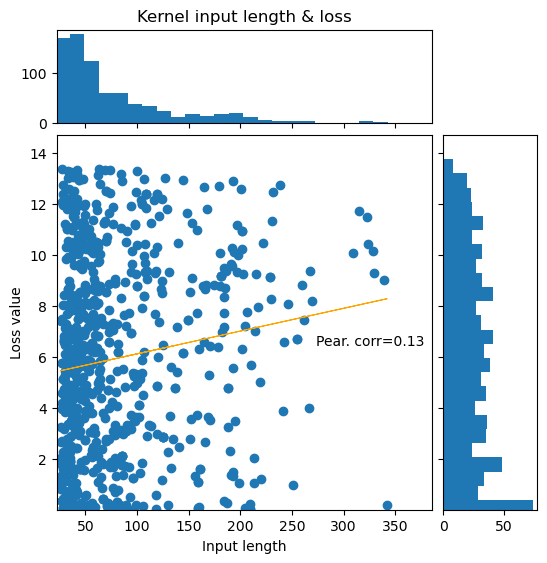

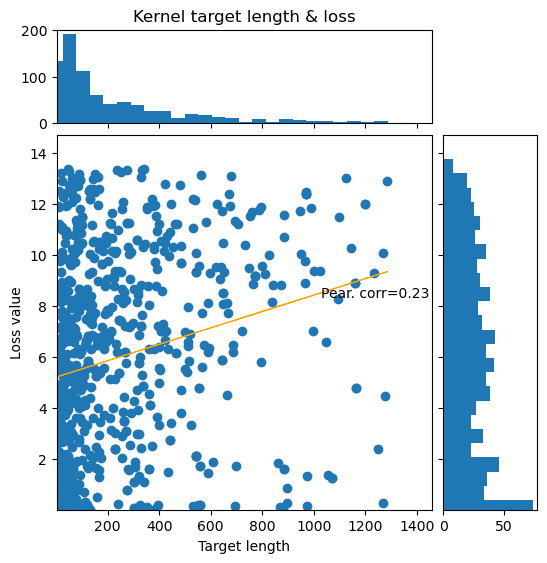

In [72]:
from sklearn.linear_model import LinearRegression 
from scipy.stats import pearsonr

def scatter_hist(x, y, ax, ax_histx, ax_histy, title):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    
    regressor = LinearRegression() 
    regressor.fit(np.array(x).reshape((len(x),1)), y)
    p_y = regressor.predict(np.array(x).reshape((len(x),1)))
    corr, _ = pearsonr(x, y)
    ax.plot(x, p_y, linewidth=0.75, color="orange")
    ax.text(max(x)*0.8, p_y[-1], f"Pear. corr={corr:.2f}")

    # now determine nice limits by hand:
    binwidth = 0.25
    
    xmax = np.max(np.abs(x))
    xlim = (int(xmax/binwidth) + 1) * binwidth
    xbins = np.linspace(-xlim, xlim + binwidth, 50)
    
    ymax = np.max(np.abs(y))
    ylim = (int(ymax/binwidth) + 1) * binwidth
    ybins = np.linspace(-ylim, ylim + binwidth, 50)

    ax_histx.hist(x, bins=xbins)
    ax_histx.set_title(title)
    ax_histy.hist(y, bins=ybins, orientation='horizontal')

def plot_scatter_with_dist(x, y, title, xlabel, ylabel):
    x = np.array(x)
    y = np.array(y)
    
    # Start with a square Figure.
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    
    min_x = np.quantile(x, 0.05)
    max_x = np.quantile(x, 0.95)
    min_y = np.quantile(y, 0.05)
    max_y = np.quantile(y, 0.95)
    
    # x_mask = np.where(x > min_x and x < max_x)
    # x = x[x_mask]
    x_mask = ((x > min_x) & (x < max_x))
    x = x[x_mask]
    y = y[x_mask]
    y_mask = ((y > min_y) & (y < max_y))
    x = x[y_mask]
    y = y[y_mask]
    
    # Draw the scatter plot and marginals.
    scatter_hist(x, y, ax, ax_histx, ax_histy, title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(min_x*0.9, max_x*1.1)
    ax.set_ylim(min_y*0.9, max_y*1.1)
    plt.show()
    
    
target_len_list = np.array(target_len_list)
input_len_list = np.array(input_len_list)
loss_list = np.array(loss_list)

plot_scatter_with_dist(input_len_list, loss_list, "Kernel input length & loss", "Input length", "Loss value")
plot_scatter_with_dist(target_len_list, loss_list, "Kernel target length & loss", "Target length", "Loss value")


In [ ]:
prd_sample_len = []
tgr_sample_len = []

for prd, (_, tgr) in (pred_sentences, l[len(pred_sentences):]):
    prd_sample_len.append(len(prd))
    tgr_sample_len.append(len(tgr))

plot_scatter_with_dist(prd_sample_len, tgr_sample_len, "Prediction & target length", "Predic. length", "Target length")


### Analyze use of indices

In [6]:
global_c = 0
global_f = 0
other_c = 0
other_f = 0

for src, prd in tqdm(list(zip(model_d.get("source_sentences"), model_d.get("pred_sentences")))):
    one_line_src = src.replace("\n", " ")
    is_global = one_line_src.find("__global__") != -1
    
    prd_lines = prd.splitlines()
    found = False
    for line in prd_lines:
        if line.find("threadIdx.") != -1 and line.find("blockIdx.") != -1 and line.find("blockDim.") != -1:
            if is_global:
                global_c += 1
            else:
                other_f += 1
            found = True
            break
        
    if not found:
        if is_global:
            global_f += 1
        else:
            other_c += 1

print(f"global_c: {global_c} ({global_c/(global_c+global_f):.2%})")
print(f"global_f: {global_f} ({global_f/(global_c+global_f):.2%})")
print(f"others_c: {other_c} ({other_c/(other_c+other_f):.2%})")
print(f"others_f: {other_f} ({other_f/(other_c+other_f):.2%})")

total = global_c + global_f + other_c + other_f
correct = global_c + other_c
incorrect = global_f + other_f
print(f"Correct: {correct} ({correct/total:.2%})")
print(f"Incorrect: {incorrect}, ({incorrect/total:.2%})")

  0%|          | 0/38879 [00:00<?, ?it/s]

global_c: 0 (0.00%)
global_f: 15217 (100.00%)
others_c: 23662 (100.00%)
others_f: 0 (0.00%)
Correct: 23662 (60.86%)
Incorrect: 15217, (39.14%)


### Use of local memory analyses

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score
t_p = 0
t_n = 0
f_p = 0
f_n = 0

t = []
p = []

for tgr, prd in tqdm(list(zip(model_d.get("target_sentences"), model_d.get("pred_sentences")))):
    tgr_l_m_use = tgr.find("__shared__") != -1 or tgr.find("__constant__") != -1
    prd_l_m_use = prd.find("__shared__") != -1 or prd.find("__constant__") != -1
    
    if tgr_l_m_use:
        if prd_l_m_use:
            t_p += 1
        else:
            f_n += 1
    else:
        if prd_l_m_use:
            f_p += 1
        else:
            t_n += 1
            
    t.append(tgr_l_m_use)
    p.append(prd_l_m_use)
    
total = t_p + t_n + f_p + f_n
print(f"True positive: {t_p}\t({t_p/total:.2%})")
print(f"True negative: {t_n}\t({t_n/total:.2%})")
print(f"False positive: {f_p}\t({f_p/total:.2%})")
print(f"False negative: {f_n}\t({f_n/total:.2%})")

precision = precision_score(t, p)
recall = recall_score(t, p)
f1 = f1_score(t, p)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}")

  0%|          | 0/38879 [00:00<?, ?it/s]

True positive: 567	(1.46%)
True negative: 33628	(86.49%)
False positive: 1209	(3.11%)
False negative: 3475	(8.94%)
Precision: 0.319
Recall: 0.140
F1: 0.195
